# Source Code

## 0. Overview

This source code provides a detailed pipeline of gathering data from Reddit and the stock market, cleaning it, performing sentiment analysis, and graphing the results. While this code should be fairly robust, we recommend running it on Google Colab for best performance (assuming the dataset is small enough to perform).

*There are 6 major steps in this pipeline:*

1. **Data Gathering:** This is where the data is gathered, through the help of two different APIs. The PMAW API is used to gather data from Reddit, allowing the user to either pull from a subreddit's collection of posts, or comments on the posts. Yahoo's YFinance API allows us to get stock price data for any given stock.

2. **Data Cleaning:** Once the Reddit data is pulled from the internet, it needs to be cleaned. There are a lot of posts/comments that have been deleted or removed since originally being posted, and some that don't have any content. Afte these are removed, the creation date is reformatted into a YYYY-MM-DD string format. 

3. **Sentiment Analysis:** After the Reddit data is cleaned, we can perform sentiment analysis on it. Google's BERT sentiment analysis model can be downloaded and used for this step. 

4. **Data Selection for Graphing:** Once the Reddit data is cleaned and passed through the sentiment analysis, we need to compare it to the stock market data. There are holes in the Reddit data since many posts/comments have been deleted or removed since their original upload, and there is no stock market data from weekends or holidays. Thus, we need to find a set of usable dates that both datasets have entries for. This step also removes all unnecessary field from the data to prepare it for graphing.

5. **ASAP Open Source Data Smoothing:** The sentiment data alone is incredibly volatile and messy, so data smoothing is needed. The ASAP model for smoothing data works great, and is applied to the Reddit sentiment data. The source code from this step is the entirety of the open source code fro the ASAP model.

6. **Final Graphing:** This step takes in the data from step 4 and feeds it into step 5, producing a dataset that is ready to be plotted. It returns a dataframe containing the smoothed out data, so it can be exported and plotted in something like Plot.Ly.

In [ ]:
# Please run this cell first, as most future code blocks utilize the libraries included below:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

## 1.1. Data Gathering - Reddit

This section of code is used to gather reddit data. PMAW is used, and can be found at [https://github.com/mattpodolak/pmaw ](https://github.com/mattpodolak/pmaw ).

**NOTE:** If gathering data, this should be run as a local jupyter notebook instead of on Google Colab if the file size is too large.

In [ ]:
!pip install pmaw

     |████████████████████████████████| 176 kB 5.9 MB/s 
     |████████████████████████████████| 53 kB 1.5 MB/s 


In [ ]:
from pmaw import PushshiftAPI

In [ ]:
def getRedditData(subreddit, output_file, is_posts, content_limit=100000):
  '''
  A function to get content (either posts or comments) 
  from a subreddit and save it to a csv file
  INPUT:  subreddit   - case-sensitive string of desired subreddit name
          output_file - string name of file to output data to
          is_posts    - boolean value indicating if user wants posts (true) or comments (false)
          count_limit - limit of posts/comments to download (default 100,000)
  OUTPUT: dataframe containing pulled data
  '''
  api = PushshiftAPI()
  # get posts
  if is_posts is True:
    content = api.search_submissions(subreddit=subreddit, limit=content_limit)
  # get comments
  else:
    content = api.search_comments(subreddit=subreddit, limit=content_limit)
  # save content to dataframe
  content_df = pd.DataFrame(content)
  # write output csv
  content_df.to_csv(output_file, header=True, index=False, columns=list(content_df.axes[1]))

  return content_df

## 1.2. Data Gathering - Finance

This section of code is used to gather stock price data. For this, yfinance is used, info for which can be found at [https://pypi.org/project/yfinance/](https://pypi.org/project/yfinance/).

**NOTE:** If gathering data, this should be run as a local jupyter notebook instead of on Google Colab if the file size is too large.

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 5.2 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf

In [ ]:
def getFinanceData(stock_name, output_file, start_date, end_date):
  '''
  A function to get finance data for a specific stock and 
  write it to a CSV file.
  INPUT:  stock_name  - string name of stock
          output_file - string name of file to write to
          start_date  - string of start date for data
          end_date    - string of end date for data
  OUTPUT: dataframe containing pulled data
  '''
  # get stock prices
  msft = yf.Ticker(stock_name)
  hist = msft.history(period="max")
  data = yf.download(stock_name, start=start_date, end=end_date)
  # fix date as a column
  data.insert(0, 'Date', data.index)
  data.reset_index(drop=True, inplace=True)
  data['Date'] = data['Date'].astype(str)
  # write output csv
  data.to_csv(output_file, header=True, index=False, columns=list(data.axes[1]))
  return data

## 2. Data Cleaning

After getting the data, this section of code cleans the data and reduces it to only the usable (graphable) values.

In [ ]:
def cleanTimestamps(df):
  '''
  A helper function to remove rows of data with bad dates, 
  then reformat all dates to YYYY-MM-DD string format.
  INPUT: df - dataframe to reformat
  OUTPUT: reformatted dataframe
  '''

  # remove posts with invalid timestamps
  df = df.dropna(subset=['created_utc'])
  null_df = df.created_utc.isnull()
  df = df[null_df == False]
  df = df[df.created_utc != "[deleted]"]
  df = df[df.created_utc != "[removed]"]

  # remove incorrectly formatted timestamps
  rows_to_keep = []
  with tqdm(total=len(df)) as pbar:
    for i in range(len(df)):
      rows_to_keep.append(not isinstance(df.iloc[i].created_utc, str))
      pbar.update(1)
  df = df[rows_to_keep]

  # create formatted timestamps
  sub_dates = []
  for time in df['created_utc']:
    fts = datetime.utcfromtimestamp(time).strftime('%Y-%m-%d')
    sub_dates.append(fts)

  # append new timestamps
  df['Date'] = sub_dates
  df = df.sort_values(by=['Date'])

  return df

In [ ]:
def cleanRedditPosts(input_file, output_file, input_df=None, use_df=False):
  '''
  A function that cleans reddit post data, removing bad entries and 
  fixing the date fields.
  INTPUT: input_file  - string name of data file
          output_file - string name of file to write to
          input_df    - input database, replaces input_file
          use_df      - boolean indicating whether or not to use input_df instead of input_file
  OUTPUT: dataframe containing cleaned reddit posts
  '''

  # get input data
  if use_df == False:
    posts_df = pd.read_csv(input_file)
  else:
    posts_df = input_df.copy()

  # remove invalid posts
  null_posts_df = posts_df.selftext.isnull()
  posts_df = posts_df[null_posts_df == False]
  posts_df = posts_df[posts_df.selftext != "[deleted]"]
  posts_df = posts_df[posts_df.selftext != "[removed]"]

  # remove posts whose content is too long
  posts_df = posts_df[posts_df.selftext.apply(lambda x: len(str(x)) < 512)]

  # clean timestamps
  posts_df = cleanTimestamps(posts_df)

  # write output csv
  posts_df.to_csv(output_file, header=True, index=False, columns=list(posts_df.axes[1]))

  return posts_df

In [ ]:
def cleanRedditComments(input_file, output_file, input_df=None, used_df=False):
  '''
  A function that cleans reddit comments data, removing bad entries and 
  fixing the date fields.
  INTPUT: input_file  - string name of data file
          output_file - string name of file to write to
          input_df    - input database, replaces input_file
          use_df      - boolean indicating whether or not to use input_df instead of input_file
  OUTPUT: dataframe containing cleaned reddit comments
  '''

  # get input data
  if use_df == False:
    comments_df = pd.read_csv(input_file)
  else:
    comments_df = input_df.copy()

  # remove invalid posts
  null_comments_df = comments_df.body.isnull()
  comments_df = comments_df[null_comments_df == False]
  comments_df = comments_df[comments_df.body != "[deleted]"]
  comments_df = comments_df[comments_df.body != "[removed]"]

  # remove posts whose content is too long
  comments_df = comments_df[comments_df.body.apply(lambda x: len(str(x)) < 512)]

  # clean timestamps
  comments_df = cleanTimestamps(comments_df)

  # write data to csv
  comments_df.to_csv(output_file, header=True, index=False, columns=list(comments_df.axes[1]))

  return comments_df

## 3. Sentiment Analysis

This section of code is used to perform sentiment analysis on the reddit content. Google's BERT (Bidirectional Encoder Representations from Transformers) model is downloaded and used for this process (see research paper for more information: [https://arxiv.org/pdf/1810.04805.pdf](https://arxiv.org/pdf/1810.04805.pdf)).

In [ ]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.4 MB/s eta 0:13:46tcmalloc: large alloc 1147494400 bytes == 0x564315388000 @  0x7f8c8094f615 0x5642dadae4cc 0x5642dae8e47a 0x5642dadb12ed 0x5642daea2e1d 0x5642dae24e99 0x5642dae1f9ee 0x5642dadb2bda 0x5642dae24d00 0x5642dae1f9ee 0x5642dadb2bda 0x5642dae21737 0x5642daea3c66 0x5642dae20daf 0x5642daea3c66 0x5642dae20daf 0x5642daea3c66 0x5642dae20daf 0x5642dadb3039 0x5642dadf6409 0x5642dadb1c52 0x5642dae24c25 0x5642dae1f9ee 0x5642dadb2bda 0x5642dae21737 0x5642dae1f9ee 0x5642dadb2bda 0x5642dae20915 0x5642dadb2afa 0x5642dae20c0d 0x5642dae1f9ee
     |█████████████████               | 1055.7 MB 3.0 MB/s eta 0:05:09tcmalloc: large alloc 1434370048 bytes == 0x5643599de000 @  0x7f8c8094f615 0x5642dadae4cc 0x5642dae8e47a 0x5642dadb12ed 0x5642daea2e1d 0x5642dae24e99 0x5642dae1f9ee 0x5642dadb2bda 0x5642dae24d00 0x5642dae1f9ee 0x5642dadb2bda 0x5642dae21737 0x5642daea3c66 0x5642dae20d

In [ ]:
!pip install transformers requests beautifulsoup4 pandas numpy

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 43.9 MB/s 
     |████████████████████████████████| 61 kB 473 kB/s 
     |████████████████████████████████| 895 kB 51.8 MB/s 
     |████████████████████████████████| 596 kB 55.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [ ]:
def getSentiment(input_file, output_file, is_posts, input_df=None, use_df=False):
  '''
  A function that runs reddit content (posts or comments) through a sentiment 
  model, assigning a score from 1 to 5 (bad to good).
  INTPUT: input_file  - string name of data file
          output_file - string name of file to write to
          is_posts    - boolean indicating posts (true) or comments (false)
          input_df    - input database, replaces input_file
          use_df      - boolean indicating whether or not to use input_df instead of input_file
  OUTPUT: dataframe containing data with appended sentiment score
  '''

  # get input data
  if use_df == False:
     df = pd.read_csv(input_file)
  else:
    df = input_df.copy()

  # create new sentiment column
  df['Sentiment'] = ""

  # instantiate model
  tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
  model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

  # perform sentiment analysis
  with tqdm(total=len(df)) as pbar:
    for i in range(len(df)):
      tokens = []
      # analyze post
      if is_posts is True:
        tokens = tokenizer.encode(df.iloc[i].selftext, return_tensors='pt')
      # analyze comment
      else:
        tokens = tokenizer.encode(df.iloc[i].body, return_tensors='pt')
      result = model(tokens)
      # df['Sentiment'].iloc[i] = (int(torch.argmax(result.logits))+1)
      df['Sentiment'].iloc[i] = (int(torch.argmax(result.logits))+1)
      pbar.update(1)

  # write output file
  df.to_csv(output_file, header=True, index=False, columns=list(df.axes[1]))

  return df

## 4. Data Selection for Graphing

This section of code performs final preparations on the data, getting it ready to be graphed. After data cleaning, the number of data points per day is not consistent between datasets, so this code handles that.

In [ ]:
from statistics import mean

In [ ]:
def averageDailySentiment(df):
  '''
  A helper function that averages the sentiment score for each day.
  INPUT: dataframe to average daily sentiment
  OUTPUT: dataframe with averaged daily sentiment
  '''

  # iterate over data, counting frequency of dates
  sentiment_dict = {}
  for i in range(len(df)):
    key = df.loc[i,'Date']
    value = df.loc[i,'Sentiment']
    # add new dates to dict
    if key not in sentiment_dict:
      sentiment_dict[key] = [value]
    # update count of existing dates
    else:
      sentiment_dict[key].append(value)

  dates=[]
  sentiments=[]

  # create new dataframe with daily average sentiment
  for key in sentiment_dict:
    value = mean([float(x) for x in sentiment_dict[key]])
    value = int(round(value))
    dates.append(key)
    sentiments.append(value)

  df = pd.DataFrame(list(zip(dates, sentiments)), columns=['Date', 'Sentiment'])

  return df

In [ ]:
def getDateAndSentiment(input_file, output_file, input_df=None, use_df=False):
  '''
  A function that averages daily sentiment from an entire reddit content database 
  and returns cleaned data of just the plottable fields.
  INTPUT: input_file  - string name of data file
          output_file - string name of file to write to
          input_df    - input database, replaces input_file
          use_df      - boolean indicating whether or not to use input_df instead of input_file
  OUTPUT: dataframe only containing cleaned date and sentiment fields
  '''

  # get input data
  if use_df == False:
    raw_df = pd.read_csv(input_file)
  else:
    raw_df = input_df.copy()
    raw_df.reset_index(drop=True, inplace=True)
  # create new df with just dates and sentiment
  filtered_df = raw_df[['Date', 'Sentiment']].copy()
  # average the daily sentiment
  filtered_df = averageDailySentiment(filtered_df)
  # write output csv
  filtered_df.to_csv(output_file, header=True, index=False, columns=list(filtered_df.axes[1]))
  return filtered_df

In [ ]:
def getUsableData(sentiment_input_file, finance_input_file, 
                  sentiment_output_file, finance_output_file, 
                  sentiment_input_df=None, finance_input_df=None,
                  use_sentiment_df=False, use_finance_df=False):
  '''
  A function that takes in the reddit and finance data, 
  outputting graphable overlaps of the data (dates need to line up).
  INPUT:  sentiment_input_file  - string name of sentiment input file
          finance_input_file    - string name of finance input file
          sentiment_output_file - string name of file to output sentiment to
          finance_output_file   - string name of file to output finance to
          sentiment_input_df    - dataframe to override sentiment_input_file
          finance_input_df      - dataframe to override finance_input_file
          use_sentiment_df      - boolean for whether or not sentiment_input_df replaces sentiment_input_file
          use_finance_df        - boolean for whether or not finance_input_df replaces finance_input_file
  OUTPUT: dataframe of graphable sentiment, dataframe of graphable finance
  '''

  # get sentiment input data
  if use_sentiment_df == False:
    sentiment_df = pd.read_csv(sentiment_input_file)
  else:
    sentiment_df = sentiment_input_df.copy()
  
  # get finance input data
  if use_finance_df == False:
    finance_df = pd.read_csv(finance_input_file)
  else:
    finance_df = finance_input_df.copy()

  # get list of dates
  sentiment_dates = list(sentiment_df.loc[:,'Date'])
  finance_dates = list(finance_df.loc[:,'Date'])

  # find date overlaps
  usable_dates = []
  for i in range(len(sentiment_dates)):
    if sentiment_dates[i] in finance_dates:
      usable_dates.append(sentiment_dates[i])
  
  # print(sentiment_dates)
  # print()
  # print()
  # print(finance_dates)

  # create graphable sentiment dataframe
  sentiment_list = []
  for i in range(len(sentiment_df)):
    date = sentiment_df.loc[i,'Date']
    sentiment = sentiment_df.loc[i,'Sentiment']
    if date in usable_dates:
      sentiment_list.append((date,sentiment))
  graphable_sentiment_df = pd.DataFrame(sentiment_list, columns=['Date','Sentiment'])

  # create graphable finance dataframe
  finance_list = []
  for i in range(len(finance_df)):
    date = finance_df.loc[i,'Date']
    price = finance_df.loc[i,'Close']
    if date in usable_dates:
      finance_list.append((date,price))
  graphable_finance_df = pd.DataFrame(finance_list, columns=['Date','Price'])

  # write output csv
  graphable_sentiment_df.to_csv(sentiment_output_file, header=True, index=False, columns=list(graphable_sentiment_df.axes[1]))
  graphable_finance_df.to_csv(finance_output_file, header=True, index=False, columns=list(graphable_finance_df.axes[1]))

  return graphable_sentiment_df, graphable_finance_df

## 5. ASAP Open Source Data Smoothing

This section of code is the open-source code for the ASAP data smoothing API. Slight modifications were made to make it python3-compatible. Information on this API can be found here: [https://dawn.cs.stanford.edu/2017/08/07/asap/](https://dawn.cs.stanford.edu/2017/08/07/asap/)

In [ ]:
import sys
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import pandas as pd
import json
import numpy.fft
from decimal import Decimal
import math

%matplotlib inline

In [ ]:
# ASAP Simple (Brute Force)
def moving_average(data, _range):
    ret = np.cumsum(data, dtype=float)
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    ret = moving_average(data, _range)[::slide]
    return list(ret)

def kurtosis(values):
    return scipy.stats.kurtosis(values)

def roughness(vals):
    return np.std(np.diff(vals))

def smooth_simple(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    window_size = 1
    slide_size = 1
    if resolution:
        slide_size = int(len(data) / resolution)
        if slide_size > 1:
            data = SMA(data, slide_size, slide_size)
    orig_kurt   = kurtosis(data)
    min_obj     = roughness(data)
    max_window = int(max_window) #ADDED LINE
    for w in range(2, int(len(data) / max_window + 1)): #ADDED INT CASTING
        smoothed = SMA(data, w, 1)
        if kurtosis(smoothed) >= orig_kurt:
            r = roughness(smoothed)
            if r < min_obj:
                min_obj = r
                window_size = w
    return window_size, slide_size

In [ ]:
# ASAP
class Metrics(object):
    def __init__(self, values):
        self.set_values( values )

    def set_values(self, values):
        self.values = values
        self.r = self.k = None

    @property
    def kurtosis(self):
        if self.k is None:
            self.k = scipy.stats.kurtosis(self.values)
        return self.k

    @property
    def roughness(self):
        if self.r is None:
            self.r = np.std(np.diff(self.values))
        return self.r

class ACF(Metrics):
    CORR_THRESH = 0.2
    def __init__(self, values, max_lag=None):
        super(ACF, self).__init__(values)
        if max_lag is None:
            max_lag = len(values) / 5
        self.max_lag = int(max_lag)
        self.max_acf = 0.0

        # Calculate autocorrelation via FFT
        # Demean
        demeaned = values - np.mean(values)
        # Pad data to power of 2 
        l = int(2.0 ** (int(math.log(len(demeaned),2.0)) + 1))
        padded = np.append(demeaned, ([0.0] * (l - len(demeaned))))    
        # FFT and inverse FFT
        F_f = numpy.fft.fft( padded )
        R_t = numpy.fft.ifft( F_f * np.conjugate(F_f) )
        max_lag = int(max_lag) #ADDED LINE
        self.correlations = R_t[:max_lag].real / R_t[0].real
        
        # Find autocorrelation peaks 
        self.peaks = []
        if len(self.correlations) >1 :
            positive = self.correlations[1] > self.correlations[0]
            max = 1
            for i in range(2, len(self.correlations)):
                if not positive and self.correlations[i] > self.correlations[i-1]:
                    max = i
                    positive = not positive
                elif positive and self.correlations[i] > self.correlations[max]:
                    max = i
                elif positive and self.correlations[i] < self.correlations[i-1]:
                    if max > 1 and self.correlations[max] > self.CORR_THRESH:
                        self.peaks.append(max)
                        if self.correlations[max] > self.max_acf:
                            self.max_acf = self.correlations[max]
                    positive = not positive
        # If there is no autocorrelation peak within the MAX_WINDOW boundary,
        # try windows from the largest to the smallest 
        if len(self.peaks) <= 1:
            self.peaks = range(2, len(self.correlations))
                    
def moving_average(data, _range):
    ret = np.cumsum(data)
    _range = int(_range) #ADDED LINE
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    _range = int(_range) #ADDED LINE
    slide = int(slide) #ADDED LINE
    ret = moving_average(data, _range)[::slide]
    return list(ret)
                    
def binary_search(head,tail,data,min_obj,orig_kurt,window_size):
    while head <= tail:
        w = int(round((head + tail) / 2.0))
        smoothed = SMA(data,w,1)
        metrics  = Metrics(smoothed)
        if metrics.kurtosis >= orig_kurt:
            if metrics.roughness < min_obj:
                window_size = w
                min_obj = metrics.roughness
            head = w + 1
        else:
            tail = w - 1
    return window_size

def smooth_ASAP(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    slide_size = 1
    window_size = 1
    if resolution and len(data) >= 2 * resolution:
        slide_size = len(data) / resolution
        data = SMA(data, slide_size, slide_size)
    acf         = ACF(data, max_lag=len(data) / max_window)
    peaks       = acf.peaks
    orig_kurt   = acf.kurtosis
    min_obj     = acf.roughness
    lb          = 1
    largest_feasible = -1
    tail = len(data) / max_window
    for i in range(len(peaks) - 1, -1, -1):
        w = peaks[i]

        if w < lb or w == 1:
            break
        elif math.sqrt(1 - acf.correlations[w]) * window_size > math.sqrt(1 - acf.correlations[window_size]) * w:
            continue

        smoothed = SMA(data, w, 1)
        metrics = Metrics(smoothed)
        if metrics.roughness < min_obj and metrics.kurtosis >= orig_kurt:
            min_obj = metrics.roughness
            window_size = w
            lb = round( max(w*math.sqrt( (acf.max_acf -1) / (acf.correlations[w]-1) ), lb) )
    if largest_feasible > 0:
        if largest_feasible < len(peaks) - 2:
            tail = peaks[largest_feasible + 1]
        lb = max(lb, peaks[largest_feasible] + 1)

    window_size = binary_search(lb, tail, data, min_obj, orig_kurt, window_size)
    return window_size, slide_size

In [ ]:
# Read data from CSV
def load_csv(fname, input_column=1):
    import csv
    with open(fname, 'r') as ifh:
        icsv = csv.reader(ifh)
        if sys.version_info.major == 2:
            header = icsv.next()
        else:
            header = next(icsv)
        rows = list(icsv)

        try:
            data = [ float(x[input_column]) for x in rows ]
        except ValueError:
            print("couldn't convert input-column={0} float".format(input_column))
            if rows:
                print("first row:")
                for idx,x in enumerate(rows[0]):
                    print('  column {:3d}: {}'.format(idx,x))
            exit(1)
    return data

In [ ]:
# Plot time series before and after smoothing
def plot(data, window_size, slide_size):
    plt.clf()
    plt.figure()
    data = SMA(data, slide_size, slide_size)
    method_names = ["Original", "Smoothed"]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    smoothed = SMA(data, window_size, 1)
    smoothed_range = range(int(window_size/2), int(window_size/2) + len(smoothed))
    ax1.set_xlim(0, len(data))
    ax1.plot(data, linestyle='-', linewidth=1.5)
    ax2.plot(smoothed_range, smoothed, linestyle='-', linewidth=1.5)
    axes = [ax1, ax2]
    for i in range(2):
        axes[i].get_xaxis().set_visible(False)
        axes[i].text(0.02, 0.8, "%s" %(method_names[i]),
            verticalalignment='center', horizontalalignment='left',
            transform=axes[i].transAxes, fontsize=25)

    fig.set_size_inches(16, 6)
    plt.tight_layout(w_pad=1)
    plt.show()

## 6. Final Graphing

This was code we added to utilize the ASAP API and produce graphs with the smoothed sentiment data.

In [ ]:
def getSmoothedDataFrame(input_file, smoothed_list, smoothed_range):
  '''
  A funciton that converts ASAP-smoothed data into its own dataframe
  INTPUT: input_file  - string name of data file
          output_file - string name of file to write to
          input_df    - input database, replaces input_file
          use_df      - boolean indicating whether or not to use input_df instead of input_file
  OUTPUT: dataframe only containing cleaned date and sentiment fields
  '''
  
  smoothed_df = pd.read_csv(input_file)
  smoothed_df = smoothed_df[smoothed_range[0]:smoothed_range[-1]+1].copy()
  smoothed_df['Sentiment'] = smoothed_list
  return smoothed_df

In [ ]:
def plot_multiple(dataToSmooth, dataToCompare, window_size, slide_size, plot_name, finance_label):
  '''
  A function takes in graphable data, smooths the sentiment, produces a graph, 
  then returns a dataframe of the smoothed data and its range. Called by the 
  sentimentVsFinance function.
  INTPUT: dataToSmooth  - list of sentiment data to smooth and plot
          dataToCompare - list of finance data to plot
          window_size   - int provided by ASAP API for optimization
          slide_size    - int provided by ASAP API for optimization
          plot_name     - string of desired plot title
          finance_label - string of finance axis label (due to log normalization)
  OUTPUT: dataframe containing smoothed data, range containing indices of smoothed data
  '''

  # smooth data
  temp = SMA(dataToSmooth, slide_size, slide_size)
  smoothed = SMA(temp, window_size, 1)
  smoothed_range = range(int(window_size/2), int(window_size/2) + len(smoothed))
  
  fig, ax1 = plt.subplots()

  # plot sentiment
  color1 = 'tab:red'
  ax1.set_xlabel('Date') # used for both plots
  ax1.set_xticklabels([])
  ax1.set_ylabel('r/Disney Sentiment (scaled 1-5)', color=color1, fontsize=12, labelpad=15)
  ax1.plot(smoothed_range, smoothed, color=color1, linestyle='-', linewidth=1.5)
  ax1.tick_params(axis='y', labelcolor=color1)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  # plot finance
  color2 = 'tab:blue'
  ax2.set_ylabel(finance_label, color=color2, fontsize=12, labelpad=15)
  ax2.plot(dataToCompare, color=color2, linestyle='-', linewidth=1.5)
  ax2.tick_params(axis='y', labelcolor=color2)

  # apply vertical lines
  for i in range(smoothed_range[0], smoothed_range[-1], 100):
    plt.axvline(i, color=(0,0,0,0.25))

  # plot settings
  fig.tight_layout(w_pad=1)  # otherwise the right y-label is slightly clipped
  fig.set_size_inches(16, 6)
  plt.title(plot_name, fontsize=15, pad=15)
  plt.show()

  return smoothed, smoothed_range

In [ ]:
def sentimentVsFinance(sentiment_input_file, finance_input_file, plot_name, normalize_finance=False):
  '''
  A driver function for the plot_multiple function. 
  INTPUT: sentiment_input_file - string name of sentiment input file
          finance_input_file   - string name of finance input file
          plot_name            - string of desired plot title
          normalize_finance    - boolean to determine if finance data is normalized (natural log)
  OUTPUT: dataframe only containing cleaned date and sentiment fields
  '''
  
  # load data
  sentiment_data = load_csv(sentiment_input_file)
  sentiment_data_int = [int(a) for a in sentiment_data]
  finance_data = load_csv(finance_input_file)
  # normalize stock prices
  if normalize_finance == True:
    finance_data = [np.log(x) for x in finance_data]
    finance_label = 'Natural Log of Stock Price (in USD)'
  else:
    finance_label = 'Stock Price (in USD)'
  # graph data
  window_size, slide_size = smooth_ASAP(sentiment_data_int, resolution=1920)
  # print("Window Size: ", window_size) # optional printing of window size
  smoothed, smoothed_range = plot_multiple(sentiment_data, finance_data, window_size, slide_size, plot_name, finance_label)

  return getSmoothedDataFrame(sentiment_input_file, smoothed, smoothed_range)

# Driver Code

This seciton of the notebook is meant for demoing the pipeline above. The 'Post Sentiment Pipeline Examples' and 'Comment Sentiment Pipeline Examples' sections demonstrate how to use the pipeline from beginning to end. The 'Pre-Prepared Graphs' section is set up to take input CSV files containing the pre-processed data needed to generate the output graphs.

#### Post Sentiment Pipeline Examples

Running these cells will grab posts from r/Disney, perform sentiment analysis, smooth the data, then graph them with Disney's stock prices on the same days as the posts.

In [ ]:
# Get reddit data
raw_reddit_posts_df = getRedditData('Disney', 'raw_disney_posts.csv', is_posts=True, content_limit=1000)

In [ ]:
# Get stock data
raw_finance_df = getFinanceData('DIS', 'raw_finance.csv', '2000-01-01', '2021-11-15')

In [ ]:
# Clean reddit data
cleaned_reddit_posts_df = cleanRedditPosts('', 'cleaned_disney_posts.csv', raw_reddit_posts_df, use_df=True)

In [ ]:
# Perform sentiment analysis on reddit data
reddit_posts_and_sentiment_df = getSentiment('', 'disney_posts_w_sentiment.csv', True, cleaned_reddit_posts_df, use_df=True)

In [ ]:
# Filter reddit data
reddit_sentiment_df = getDateAndSentiment('', 'disney_sentiment.csv', reddit_posts_and_sentiment_df, use_df=True)

In [ ]:
# Get graphable data files
graphable_sentiment, graphable_finance = getUsableData('', '', 'graphable_sentiment.csv', 'graphable_finance.csv', 
                                                       reddit_sentiment_df, raw_finance_df, 
                                                       use_sentiment_df=True, use_finance_df=True)

In [ ]:
# Graph data
smoothed_df = sentimentVsFinance('graphable_sentiment.csv', 'graphable_finance.csv')

#### Comment Sentiment Pipeline Examples

Running this cell will produce the same graph as the 'Post Sentiment' section above, but with comments on posts instead of the posts themselves.

In [ ]:
raw_reddit_comments_df = getRedditData('Disney', 'raw_disney_comments.csv', is_posts=False, content_limit=1000)
raw_finance_df = getFinanceData('DIS', 'raw_finance.csv', '2000-01-01', '2021-11-15')
cleaned_reddit_comments_df = cleanRedditComments('', 'cleaned_disney_comments.csv', raw_reddit_comments_df)
reddit_comments_and_sentiment_df = getSentiment('', 'disney_comments_w_sentiment.csv', False, cleaned_reddit_comments_df)
reddit_sentiment_df = getDateAndSentiment('disney_comments_w_sentiment.csv', 'disney_sentiment.csv')
graphable_sentiment, graphable_finance = getUsableData('', '', 'graphable_sentiment.csv', 'graphable_finance.csv', reddit_sentiment_df, raw_finance_df)
sentimentVsFinance('graphable_sentiment.csv', 'graphable_finance.csv')
smoothed_df = sentimentVsFinance('graphable_sentiment.csv', 'graphable_finance.csv', True)

#### Pre-Prepared Graphs

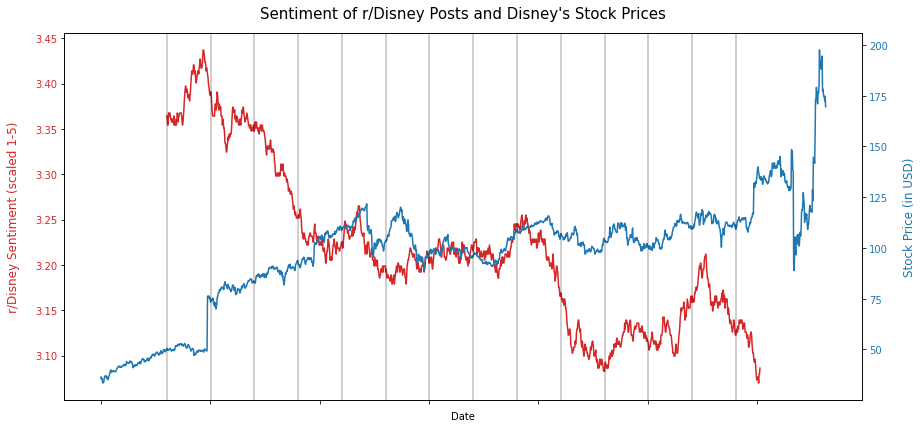

In [ ]:
# Sentiments from Posts
smoothed_df = sentimentVsFinance('GRAPHABLE_POST_SENTIMENT.csv', 'POST_FINANCE.csv', 'Sentiment of r/Disney Posts and Disney\'s Stock Prices')

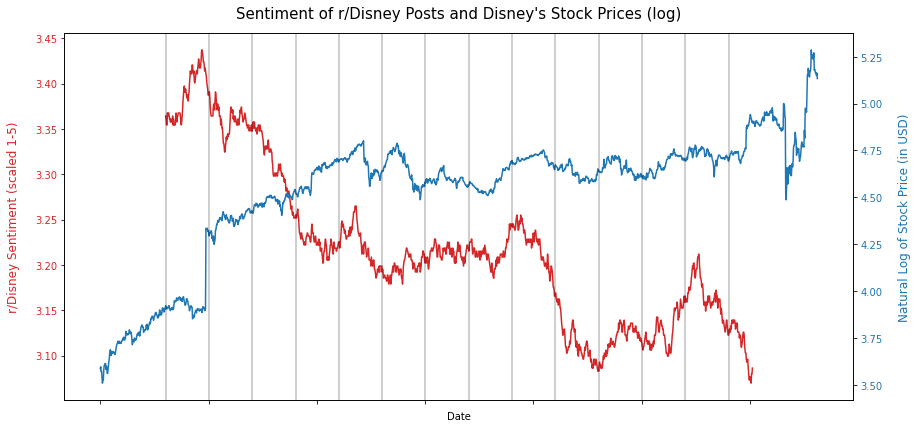

In [ ]:
# Sentiments from Posts with Normalized Stock Prices
smoothed_df = sentimentVsFinance('GRAPHABLE_POST_SENTIMENT.csv', 'POST_FINANCE.csv', 'Sentiment of r/Disney Posts and Disney\'s Stock Prices (log)', True)

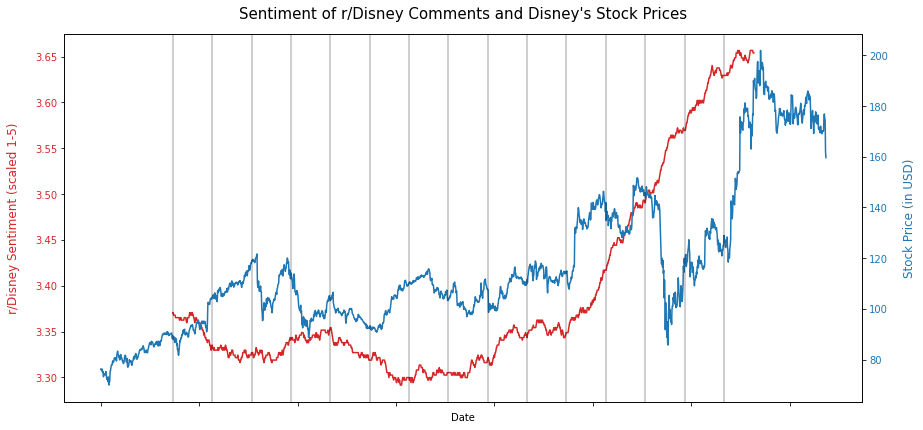

In [ ]:
# Sentiments from Comments
smoothed_df = sentimentVsFinance('GRAPHABLE_COMMENT_SENTIMENT.csv', 'COMMENT_FINANCE.csv', 'Sentiment of r/Disney Comments and Disney\'s Stock Prices')

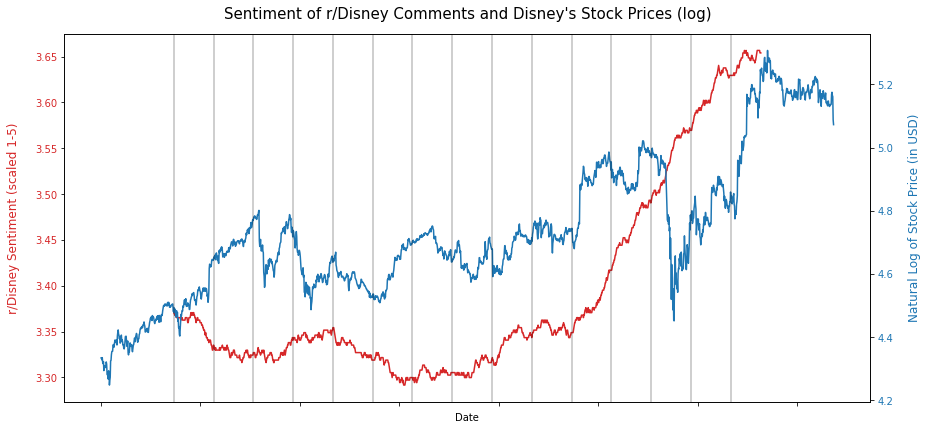

In [ ]:
# Sentiments from Comments with Normalized Stock Prices
smoothed_df = sentimentVsFinance('GRAPHABLE_COMMENT_SENTIMENT.csv', 'COMMENT_FINANCE.csv', 'Sentiment of r/Disney Comments and Disney\'s Stock Prices (log)', True)